
# 基于随机森林算法的车辆接受度预测


## 项目综述
该课程项目是使用随机森林算法预测车辆的接受度。

为了训练出一个合适的模型，我选择把树的棵树从1遍历到100。
挑选一个得到了最优模型后，使用
并观察这些表现最优的森林。项目使用基尼系数（GINI）作为树的分支划分算法。


* 数据集为Kaggle上的[Car Evaluation Data Set](https://www.kaggle.com/datasets/elikplim/car-evaluation-data-set)。

* 网上相关参考资料：
    1. [Random Forest Classifier Tutorial](https://www.kaggle.com/code/prashant111/random-forest-classifier-tutorial)
    2. [随机森林算法](https://zhuanlan.zhihu.com/p/58940946)


# 目录 <a class="anchor" id="0"></a>

1. [开发环境](#1) 
2. [数据清理和格式化](#2)
3. [探索性数据分析](#3)
4. [特征工程和特征选择](#4)
5. [解释模型结果](#5)
6. [得出结论](#6)

# **1. 开发环境** <a class="anchor" id="1"></a>
[目录](#0)

**系统**
* Ubuntu20.04

**python版本及其库版本**
* python 3.10.4
* numpy 1.22.3
* pandas 1.4.2
* category_encoders 2.5.0
* scikit-learn 1.0.1
* matplotlib 3.5.3

In [65]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
%matplotlib inline

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/car_evaluation.csv


# 2. 数据清理和格式化<a class="anchor" id="2"></a>
[目录](#0)

## 2.1 加载、检查数据

In [66]:
data_path = './data/car_evaluation.csv'

dataset = pd.read_csv(data_path, header=None)

In [67]:
dataset.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [68]:
dataset.shape

(1728, 7)

根据[数据集说明](https://www.kaggle.com/datasets/elikplim/car-evaluation-data-set)，数据集共有1728个样本。每个样本有7个属性，分别是：
* 购买费用
* 日常保养费用
* 车门数
* 载人数
* 后备箱大小
* 车辆安全程度
* 接受度

In [69]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1728 non-null   object
 1   1       1728 non-null   object
 2   2       1728 non-null   object
 3   3       1728 non-null   object
 4   4       1728 non-null   object
 5   5       1728 non-null   object
 6   6       1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


## 2.2 重命名列名

In [70]:
col_names = ['buying_price', 'maintenance_price', 'doors_number', 'manned_capacity',
             'luggage_rack_size', 'safety', 'class']

dataset.columns = col_names

# 每列的统计信息
dataset.describe()

,buying_price,maintenance_price,doors_number,manned_capacity,luggage_rack_size,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


## 2.3 检查、处理缺失值

数据集并无缺失值

In [71]:
dataset.isnull().sum()

buying_price         0
maintenance_price    0
doors_number         0
manned_capacity      0
luggage_rack_size    0
safety               0
class                0
dtype: int64

# 3. 探索性数据分析<a class="anchor" id="3"></a>


发现样本中，除了class（目标变量），其他属性的分类出现了均分的情况

In [72]:
for col in col_names:
    print(dataset[col].value_counts())

vhigh    432
high     432
med      432
low      432
Name: buying_price, dtype: int64
vhigh    432
high     432
med      432
low      432
Name: maintenance_price, dtype: int64
2        432
3        432
4        432
5more    432
Name: doors_number, dtype: int64
2       576
4       576
more    576
Name: manned_capacity, dtype: int64
small    576
med      576
big      576
Name: luggage_rack_size, dtype: int64
low     576
med     576
high    576
Name: safety, dtype: int64
unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64


# 4. 特征工程 <a class="anchor" id="4"></a>

因为本数据集中，样本的属性非常少，剔除某个属性会导致模型的训练的数据过少。
所以，我并没有除去样本中的属性。

## 4.1 划分训练集和测试级别

按照2:1的比例，随机划分

In [73]:
feature_data = dataset.drop(['class'],axis=1)

target_variable = dataset['class']


from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(feature_data, target_variable, test_size = 0.33, random_state = 40)


X_train.shape, X_test.shape

((1157, 6), (571, 6))

## 4.2 特征编码

In [74]:
import category_encoders as ce

encoder = ce.OrdinalEncoder(cols=['buying_price', 'maintenance_price', 'doors_number', 'manned_capacity',
             'luggage_rack_size', 'safety'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

# 展示各种向量
X_train.head()

,buying_price,maintenance_price,doors_number,manned_capacity,luggage_rack_size,safety
660,1,1,1,1,1,1
1447,2,2,2,1,2,2
829,1,3,3,2,3,2
1336,2,4,2,1,1,2
581,1,2,2,1,1,3


## 4.3 训练模型

**训练随机森林分类器**

In [75]:
# 需要sklearn.ensemble.RandomForestClassifier , sklearn.metrics.accuracy_score
def train_model(X_train,y_train,X_test,y_test,tree_num,show_detail=0):
    # 训练
    counter = 0
    treenums = range(1,tree_num+1)
    models = [RandomForestClassifier(num,random_state=0)for num in treenums]
    accuracy_sorces = np.zeros(tree_num)
    
    
    
    if show_detail != 0:
        for model in models:
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            accuracy_sorces[counter] = accuracy_score(y_test, y_pred)
            print('{}颗决策树的随机森林模型精确度 : {}'. format(treenums[counter],accuracy_sorces[counter]))
            counter+=1
        
    else:
        for model in models:
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            accuracy_sorces[counter] = accuracy_score(y_test, y_pred)
            counter+=1
    
    finest_model_indexes = choose_finest_model(accuracy_sorces,treenums)
    
    visualize_accuracy(accuracy_sorces,tree_num)
    
    return [models[index] for index in finest_model_indexes]



def choose_finest_model(accuracy_sorces,treenums):
    # 挑选
    max_sorce = np.max(accuracy_sorces)
    max_sorce_indexes = np.where(accuracy_sorces==max_sorce)[0]
    for i in max_sorce_indexes:
        print('{}颗决策树的随机森林,'.format(treenums[i]))
    
    print('为精确度最大的模型\n精确度：{}'.format(max_sorce))
    return max_sorce_indexes

def visualize_accuracy(accuracy_sorces,tree_num):
    x = range(1,tree_num+1)
    plt.plot(x,accuracy_sorces)
    plt.xlabel('tree_number')
    plt.ylabel('accuracy score')
    plt.show()
    


**挑选局部最优的模型**

下图展示了树的数量和准确率的关系

61颗决策树的随机森林,
63颗决策树的随机森林,
67颗决策树的随机森林,
76颗决策树的随机森林,
为精确度最大的模型
精确度：0.9719789842381786


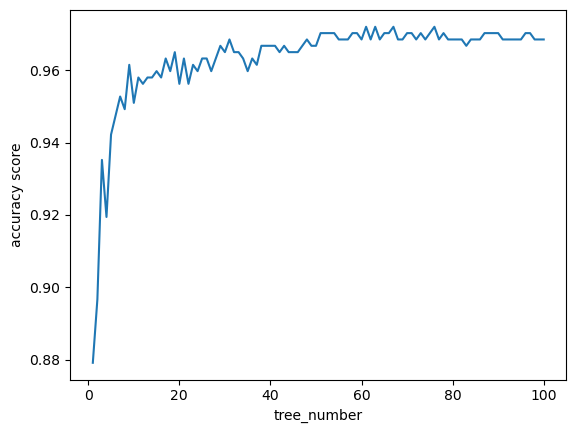

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

finest_models = train_model(X_train,y_train,X_test,y_test,tree_num=100,show_detail=0)

## 4.4 特征重要性评估

我们可以利用模型，评估数据集中的特征重要性，进行特征筛选。

如下图，综合最优秀模型的共性，luggage_rack_size和doors_number是最不重要的特征，重要性均在0.1以下。而safety是最重要的特征。


In [77]:
def visualize_feature_scores(model):
    feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    sns.barplot(x=feature_scores, y=feature_scores.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()

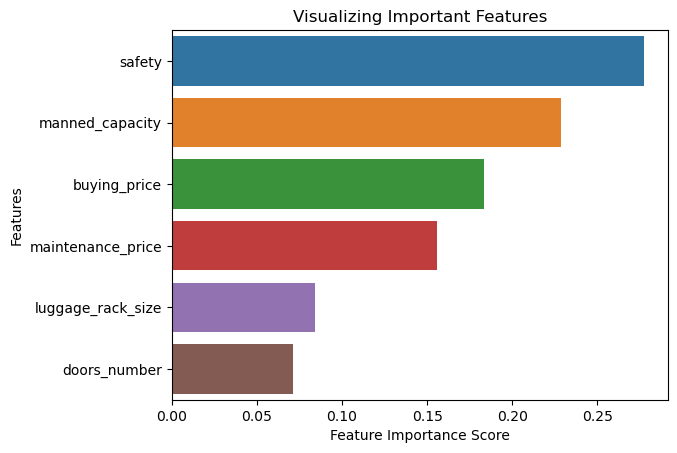

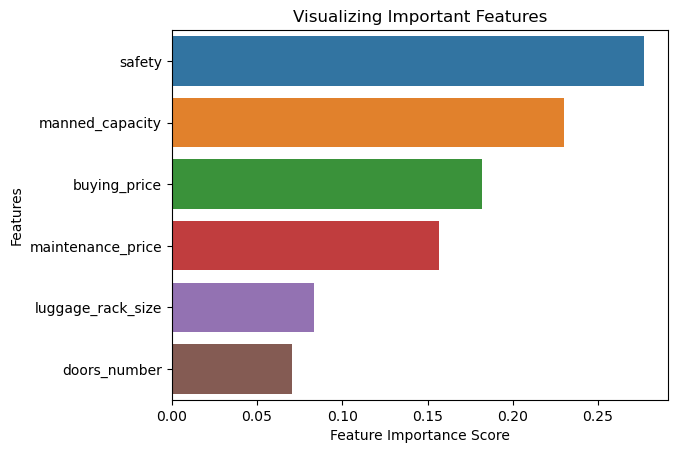

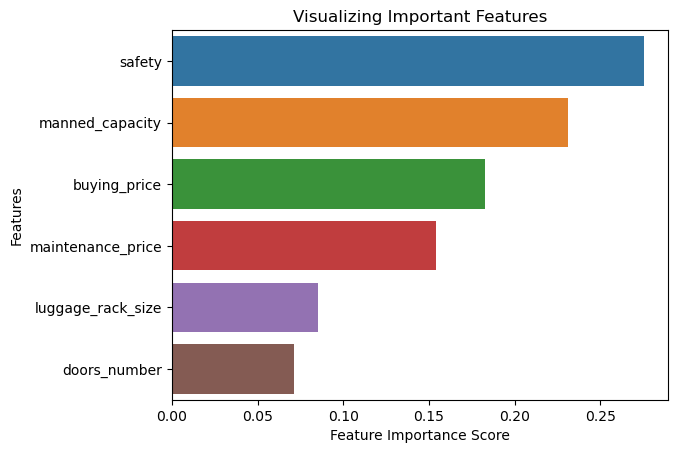

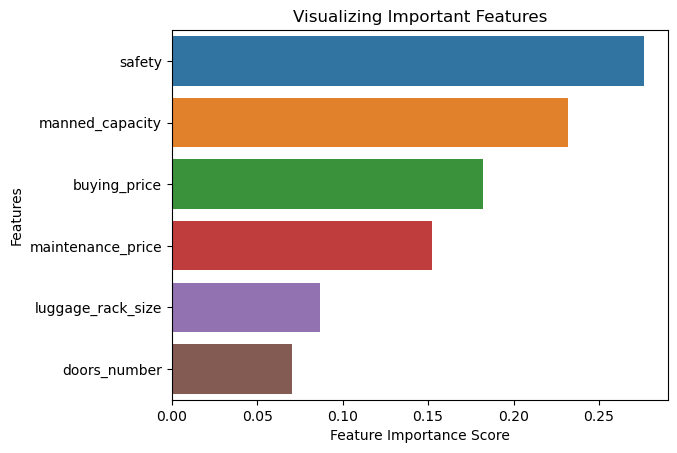

In [78]:
for model in finest_models:
    visualize_feature_scores(model)
    print()

## 4.5 模型表现评估

我们选择Confusion matrix来观察模型在具体的类别中的判断情况

可以发现，他们的判断情况完全一致

In [79]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def check_model_by_confusion_matrix(model,X_test,y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix\n\n', cm)
    print('\n\n')
    print(classification_report(y_test, y_pred))
    print('*'*90)
    
for model in finest_models:
    check_model_by_confusion_matrix(model,X_test,y_test)

Confusion matrix

 [[120   0   4   1]
 [  3  13   0   1]
 [  6   0 402   0]
 [  1   0   0  20]]



              precision    recall  f1-score   support

         acc       0.92      0.96      0.94       125
        good       1.00      0.76      0.87        17
       unacc       0.99      0.99      0.99       408
       vgood       0.91      0.95      0.93        21

    accuracy                           0.97       571
   macro avg       0.96      0.92      0.93       571
weighted avg       0.97      0.97      0.97       571

******************************************************************************************
Confusion matrix

 [[120   0   4   1]
 [  3  13   0   1]
 [  6   0 402   0]
 [  1   0   0  20]]



              precision    recall  f1-score   support

         acc       0.92      0.96      0.94       125
        good       1.00      0.76      0.87        17
       unacc       0.99      0.99      0.99       408
       vgood       0.91      0.95      0.93        21

    

## 5 模型结果分析<a class="anchor" id="5"></a>

* 随机森林模型对于这个非常小的数据集，树的数量一开始的增加可以较大程度上提高模型的准确度，但是